In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
import pandas as pd
import datetime
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import make_interp_spline

In [2]:
xr.set_options(display_style='text')

In [3]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'
sonde_file = f'{statsdir}/interpsonde_parameters_celltrack_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/'

In [4]:
# terr = xr.open_dataset(terrain_file)
# topoZ = terr['z']
# topoLon = terr['x']
# topoLat = terr['y']
# # topoZ = terr.hgt
# # topoLon = terr.longitude
# # topoLat = terr.latitude

# topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [5]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [6]:
# Read sonde data
sonde = xr.open_dataset(sonde_file)
sonde.dims['tracks']

6895

In [7]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [8]:
# Combine datasets by coordinates
stats = xr.combine_by_coords([stats2d, sat, sonde], combine_attrs='override')
stats.load()
print(stats)

<xarray.Dataset>
Dimensions:                      (reltime: 4, times: 60, tracks: 6895)
Coordinates:
  * tracks                       (tracks) int32 0 1 2 3 ... 6891 6892 6893 6894
  * reltime                      (reltime) int32 0 -1 -2 -3
  * times                        (times) int32 0 1 2 3 4 5 ... 54 55 56 57 58 59
Data variables: (12/285)
    time                         (tracks, reltime) datetime64[ns] 2018-10-16T...
    tallenough_sfc               (tracks, reltime) float32 1.0 1.0 ... 1.0 1.0
    CAPE_sfc                     (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_sfc                   (tracks, reltime) float32 nan nan ... nan nan
    CIN_NA_fract_sfc             (tracks, reltime) float32 nan nan ... nan nan
    CIN_IB_sfc                   (tracks, reltime) float32 -9.999e+03 ... -9....
    ...                           ...
    end_merge_timeindex          (tracks) float64 nan nan nan ... 1.0 nan nan
    end_merge_cloudnumber        (tracks) float64 nan nan n

In [9]:
# time_res = stats.attrs['time_resolution_hour']
tracks = stats.tracks
times = stats.times

xtimes = times * time_res
xtimes

# lifetime = stats['lifetime'] * time_res
# start_time = stats['start_basetime']
# end_time = stats['end_basetime']
# end_merge_tracknumber = stats['end_merge_tracknumber']
# start_split_tracknumber = stats['start_split_tracknumber']
# cell_lon = stats['cell_meanlon']
# cell_lat = stats['cell_meanlat']
# cell_area = stats['cell_area']
# maxrange_flag = stats['maxrange_flag']
# status = stats['status']

# eth10 = stats['maxETH_10dbz']
# eth20 = stats['maxETH_20dbz']
# eth30 = stats['maxETH_30dbz']
# eth40 = stats['maxETH_40dbz']
# eth50 = stats['maxETH_50dbz']

<xarray.DataArray 'times' (times: 60)>
array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75])
Coordinates:
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

In [10]:
start_datetime = '2019-01-25T17'
end_datetime = '2019-01-26T00'

# Find track indices that initiate within the input datetime window
idx = np.where((stats.start_basetime.values >= np.datetime64(start_datetime)) & (stats.start_basetime.values <= np.datetime64(end_datetime)))[0]

start_time = stats.start_basetime.isel(tracks=idx)
duration = stats.lifetime.isel(tracks=idx)
lifetime = duration * time_res
cell_lon = stats.cell_meanlon.isel(tracks=idx)
cell_lat = stats.cell_meanlat.isel(tracks=idx)
cell_area = stats.cell_area.isel(tracks=idx)
eth30 = stats.maxETH_30dbz.isel(tracks=idx)
eth40 = stats.maxETH_40dbz.isel(tracks=idx)
start_split_tracknumber = stats.start_split_tracknumber.isel(tracks=idx)
end_merge_tracknumber = stats.end_merge_tracknumber.isel(tracks=idx)
status = stats.status.isel(tracks=idx)
ctt = stats.cloud_top_temperature_min.isel(tracks=idx) - 273.15

In [11]:
stats.times * time_res

<xarray.DataArray 'times' (times: 60)>
array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75])
Coordinates:
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59

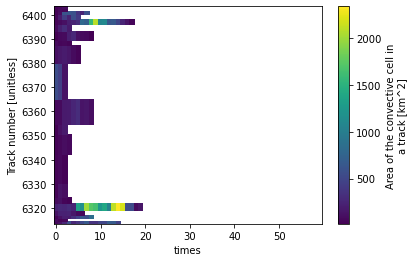

In [12]:
cell_area.where(lifetime > 0.5, drop=True).plot()

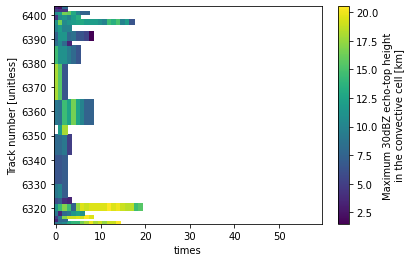

In [13]:
eth30.where(lifetime > 0.5, drop=True).plot()

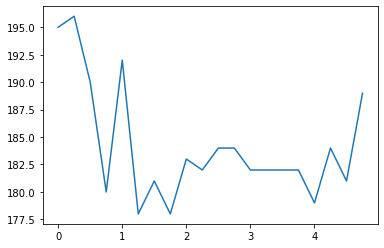

In [14]:
tracknum = 6320
# imucape = stats.CAPE_mu.sel(tracks=6314, reltime=0).values
# ilifetime = stats.lifetime.sel(tracks=6314).values * time_res
# itime0 = stats.basetime.sel(tracks=tracknum, times=0).dt.strftime('%H:%M').values
# stats.maxdbz.sel(tracks=tracknum).max(dim='times')
# stats.shear_mag_bulk_0to6km.sel(tracks=tracknum, reltime=0).values
plt.plot(xtimes, stats.cloud_top_temperature_min.sel(tracks=tracknum))
# plt.plot(xtimes, stats.cloud_top_height_max.sel(tracks=tracknum))
# plt.ylabel('Max CTH (km)')
# plt.xlabel('Hour since track')

In [15]:
stats.status.sel(tracks=6314)

<xarray.DataArray 'status' (times: 60)>
array([ 1.,  1.,  1., 13.,  4.,  1.,  1., 13.,  4.,  1.,  1.,  1., 13.,
       16., 37., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    tracks   int32 6314
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Attributes:
    long_name:  Flag indicating evolution / behavior for each cloud in a track
    units:      unitless
    valid_min:  0
    valid_max:  65
    comments:   0: Track stops;  1: Simple track continuation;  2: This is th...

In [16]:
stats.status.sel(tracks=tracknum).attrs['comments']

'0: Track stops;  1: Simple track continuation;  2: This is the bigger cloud in simple merger;  3: This is the bigger cloud from a simple split that stops at this time;  4: This is the bigger cloud from a split and this cloud continues to the next time;  5: This is the bigger cloud from a split that subsequently is the big cloud in a merger;  13: This cloud splits at the next time step;  15: This cloud is the bigger cloud in a merge that then splits at the next time step;  16: This is the bigger cloud in a split that then splits at the next time step;  18: Merge-split at same time (big merge, splitter, and big split);  21: This is the smaller cloud in a simple merger;  24: This is the bigger cloud of a split that is then the small cloud in a merger;  31: This is the smaller cloud in a simple split that stops;  32: This is a small split that continues onto the next time step;  33: This is a small split that then is the bigger cloud in a merger;  34: This is the small cloud in a merger t

In [17]:
istats = stats.status.sel(tracks=6320)
istats
# tidx_split = np.where(istats == 4)[0]
# plt.plot(xtimes[tidx_split], icell_area[tidx_split], 'o')

<xarray.DataArray 'status' (times: 60)>
array([32.,  1., 13.,  5., 15., 18., 18., 18.,  4., 13., 18., 18.,  5.,
       15., 18., 18., 18.,  4.,  1.,  0., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])
Coordinates:
    tracks   int32 6320
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Attributes:
    long_name:  Flag indicating evolution / behavior for each cloud in a track
    units:      unitless
    valid_min:  0
    valid_max:  65
    comments:   0: Track stops;  1: Simple track continuation;  2: This is th...

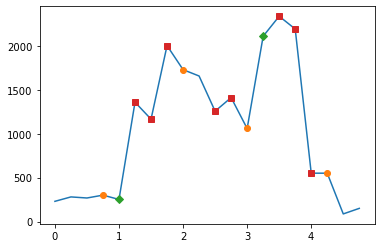

In [18]:
icell_area = stats.cell_area.sel(tracks=6320)
istats = stats.status.sel(tracks=6320)
tidx_split = np.where((istats == 4) | (istats == 5) | (istats == 16))[0]
tidx_merge = np.where((istats == 2) | (istats == 15) | (istats == 37))[0]
tidx_mergesplit = np.where((istats == 18) | (istats == 46))[0]
plt.plot(xtimes, icell_area)
plt.plot(xtimes[tidx_split], icell_area[tidx_split], 'o')
plt.plot(xtimes[tidx_merge], icell_area[tidx_merge], 'D')
plt.plot(xtimes[tidx_mergesplit], icell_area[tidx_mergesplit], 's')

In [19]:
tracknum = 6321
icell_area = stats.cell_area.sel(tracks=tracknum)
iduration = stats.lifetime.sel(tracks=tracknum).values
print(iduration)

# idx = icell_area.values > 0
# xx = xtimes.values[idx]
# yy = icell_area.values[idx]

# b, a = signal.butter(1, 0.4, analog=False)
# yy_s = signal.filtfilt(b, a, yy)

# plt.plot(xx, yy, 'o-', color='k')
# plt.plot(xx, yy_s, 'o-', color='b')

2.0


In [93]:
# tidx = np.where(stats.lifetime == 7)[0]
# cell_area = stats.cell_area.sel(tracks=tidx)
# duration = stats.lifetime.sel(tracks=tidx)
# print(f'Number of tracks: {len(tidx)}')

# tracknum = 70
# icell_area = cell_area.isel(tracks=tracknum)
# iduration = duration.isel(tracks=tracknum).values
# # Set up number of interpolated samples
# ns_interp = (iduration*4).astype(int)

# idx = icell_area.values > 0
# x = xtimes.values[idx]
# y = icell_area.values[idx]

# # Perform spline fitting interpolation
# X_Y_Spline = make_interp_spline(x, y)
# X_ = np.linspace(x.min(), x.max(), ns_interp)
# Y_ = X_Y_Spline(X_)

# # Perform low-pass filter
# b, a = signal.butter(1, 0.4, analog=False)
# Y_s = signal.filtfilt(b, a, Y_)

# # Calculate area growth/decay rate (km2/hour)
# dY = np.diff(Y_s) / np.diff(X_)
# # Get the 10th percentile absolute area change rate
# dY_thres = np.quantile(np.abs(dY), 0.1)
# # Remove times when growth rate is small (stable stage)
# dY_sub = np.copy(dY)
# dY_sub[np.abs(dY) < dY_thres] = np.nan

# fig, axes = plt.subplots(2, 1, figsize=[5,5], dpi=100)
# ax = axes[0]
# ax.plot(x, y, 'o-', color='k', label='raw')
# ax.plot(X_, Y_, 'o-', color='b', label='fit')
# ax.plot(X_, Y_s, 'o-', color='r', label='filter')
# ax.legend()
# ax.set_ylabel('Area (km$^2$)')
# ax.grid(ls='--')

# ax = axes[1]
# ax.plot(X_[:-1], dY)
# ax.plot(X_[:-1], dY_sub, 'o--', color='r')
# ax.axhline(0, color='k', ls='--')
# ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
# ax.set_xlabel('Hour since CI')
# ax.grid(ls='--')

In [191]:
a = np.array([-9])
a[a >= 0]

array([], dtype=int64)

In [214]:
def get_layer_boundary(idx, gap, min_thick):
    """
    Get contiguous layer boundary indices.
    ----------
    idx: np.array(int)
        Indices of points.
    gap: int
        If a gap larger than this exists, they are separated into different layers
    min_thick: int
        Minimum thickness of a layer.

    Returns
    ----------
    layer_start: np.ndarray(nLayers)
        Start index for each layer.
    layer_end: np.ndarray(nLayers)
        End index for each layer.
    """

    # Split idx into layers
    Layers = np.split(idx, np.where(np.diff(idx) > gap)[0]+1)
    nLayers = len(Layers)

    # Create layer_start, layer_end arrays
    layer_start = np.full(nLayers, -99, dtype=int)
    layer_end = np.full(nLayers, -99, dtype=int)

    if nLayers > 0:
        # Loop over each layer
        for iLayer in range(0, nLayers):

            # Calculate layer thickness
            zb = Layers[iLayer][0]
            zt = Layers[iLayer][-1]
            dz = zt - zb
            # A layer must be thicker than min_thick here:
            if (dz > min_thick):
                layer_start[iLayer] = zb
                layer_end[iLayer] = zt
        
        # Exclude negative (i.e., thickness <= min_thick)
        layer_start = layer_start[layer_start >= 0]
        layer_end = layer_end[layer_end >= 0]

    return layer_start, layer_end

In [215]:
def get_growth_rate1(x_in, y_in, duration, Wn):
    idx = y_in > 0
    x = x_in[idx]
    y = y_in[idx]
    
    # Set up number of interpolated samples
    ns_interp = (duration*4).astype(int)

    # Perform spline fitting interpolation
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(x.min(), x.max(), ns_interp)
    Y_ = X_Y_Spline(X_)

    # Perform low-pass filter
    b, a = signal.butter(1, Wn, analog=False)
    Y_s = signal.filtfilt(b, a, Y_)

    # Calculate area growth/decay rate (km2/hour)
    dY = np.diff(Y_s) / np.diff(X_)
    
    return (X_, Y_, Y_s, dY)

In [216]:
def get_growth_rate2(x_in, y_in, duration, Wn):
    idx = y_in > 0
    x = x_in[idx]
    y = y_in[idx]
    
    # Set up number of interpolated samples
    ns_interp = (duration*4).astype(int)
    
    # Perform low-pass filter
    b, a = signal.butter(1, Wn, analog=False)
    y_s = signal.filtfilt(b, a, y)

    # Perform spline fitting interpolation
    X_Y_Spline = make_interp_spline(x, y_s)
    X_ = np.linspace(x.min(), x.max(), ns_interp)
    Y_ = X_Y_Spline(X_)

    # Calculate area growth/decay rate (km2/hour)
    dY = np.diff(Y_) / np.diff(X_)
    
    return (X_, Y_, y_s, dY)

In [271]:
def define_growth_stage(X, dY, min_rate_percent, gap=1, min_thick=0):
    # Get the percentile for positive area change rate
    # dY_thres = np.quantile(dY[dY > 0], min_rate_percent)
    
    # Get the percentile for absolute area change rate
    dY_thres = np.quantile(np.abs(dY), min_rate_percent)
    
    # # Remove times when growth rate is small (stable stage)
    # dY_sub = np.copy(dY)
    # dY_sub[np.abs(dY) <= dY_thres] = np.nan
    
    # Get positive dY indices
    idx_p = np.where(dY > dY_thres)[0]
    # Get growth period indices
    gidx_s, gidx_e = get_layer_boundary(idx_p, gap, min_thick)
    g_dur = gidx_e - gidx_s

    # Get negative dY indices
    idx_n = np.where(dY < dY_thres)[0]
    # Get decay period indices
    didx_s, didx_e = get_layer_boundary(idx_n, gap, min_thick)
    d_dur = didx_e - didx_s

    # print('Growth:', gidx_s)
    # print('Decay:', didx_s)
    # Combine growth and decayse period start/end indices, and sort them
    idx_s = np.sort(np.concatenate((gidx_s, didx_s)))
    idx_e = np.sort(np.concatenate((gidx_e, didx_e)))
    # print('Combine:', idx_s)
    # Find growth indices in the combine index array
    junk, g1, junk = np.intersect1d(idx_s, gidx_s, return_indices=True)
    junk, d1, junk = np.intersect1d(idx_s, didx_s, return_indices=True)
    # print('Match growth index:', g1)
    # print('Match decay index:', d1)
    # Set growth period to 1, decay period to -1
    stages = np.zeros(len(idx_s), dtype=int)
    stages[g1] = 1
    stages[d1] = -1
    # print('Stages:', stages)

    growth_flag = np.zeros(len(dY), dtype=int)
    # Proceed if first stage is growth
    if stages[0] == 1:
        # Set periods of first stage to 1
        growth_flag[idx_s[0]:idx_e[0]] = 1

        # Compute stage differences
        stage_diff = np.diff(stages)
        # Find indices of consecutive growth/decay stages (diff==0)
        idx_consec = np.where(stage_diff == 0)[0]
        if len(idx_consec) > 0:
            # Loop over each consecutive stage
            for p in range(len(idx_consec)):
                # If it is a growth stage
                idxp = idx_consec[p]
                if stages[idxp] == 1:
                    # Set the next stage flag
                    growth_flag[idx_s[idxp+1]:idx_e[idxp+1]] = 1
    
    return growth_flag, dY_thres

In [220]:
tidx = np.where(stats.lifetime == 7)[0]
cell_area = stats.cell_area.sel(tracks=tidx)
duration = stats.lifetime.sel(tracks=tidx)
print(f'Number of tracks: {len(tidx)}')

for tracknum in range(len(tidx)):
# for tracknum in range(84, len(tidx)):
    # print(tracknum)
    icell_area = cell_area.isel(tracks=tracknum)
    iduration = duration.isel(tracks=tracknum).values
    # # Set up number of interpolated samples
    # ns_interp = (iduration*4).astype(int)

    idx = icell_area.values > 0
    x = xtimes.values[idx]
    y = icell_area.values[idx]

    # Fit then then low-pass filter
    Wn = 0.2
    min_rate_percent = 0.1
    X1, Y1, Ys1, dY1 = get_growth_rate1(x, y, iduration, Wn)
    # Define growth stage
    growth_flag1, dY_thres1 = define_growth_stage(X1, dY1, min_rate_percent)

    dY_hist1, bins = np.histogram(dY_sub1[dY_sub1 > 0])
    dY_avg1 = np.nanmean(dY_sub1[dY_sub1 > 0])

    # Low-pass filter then fit
    Wn2 = 0.6
    X2, Ys2, ys2, dY2 = get_growth_rate2(x, y, iduration, Wn2)
    # Define growth stage
    growth_flag2, dY_thres2 = define_growth_stage(X2, dY2, min_rate_percent)

    dY_hist2, bins = np.histogram(dY_sub2[dY_sub2 > 0])
    dY_avg2 = np.nanmean(dY_sub2[dY_sub2 > 0])


    # Get positive dY indices
    idx_p = np.where(dY1 > dY_thres1)[0]
    gap = 1
    min_thick = 1
    # Get growth period indices
    gidx_s, gidx_e = get_layer_boundary(idx_p, gap, min_thick)
    g_dur = gidx_e - gidx_s

    # Get negative dY indices
    idx_n = np.where(dY1 < dY_thres1)[0]
    # Get decay period indices
    didx_s, didx_e = get_layer_boundary(idx_n, gap, min_thick)
    d_dur = didx_e - didx_s

    # print('Growth:', gidx_s)
    # print('Decay:', didx_s)
    # Combine growth and decayse period start indices, and sort them
    idx_s = np.sort(np.concatenate((gidx_s, didx_s)))
    # print('Combine:', idx_s)
    # Find growth indices in the combine index array
    junk, g1, junk = np.intersect1d(idx_s, gidx_s, return_indices=True)
    junk, d1, junk = np.intersect1d(idx_s, didx_s, return_indices=True)
    # print('Match growth index:', g1)
    # print('Match decay index:', d1)

    stages = np.zeros(len(idx_s), dtype=int)
    stages[g1] = 1
    stages[d1] = -1
    # print(stages)
    # print(np.diff(stages))
    
    if np.count_nonzero(np.diff(stages) == 0) > 0:
        print(tracknum)

Number of tracks: 161
1
9
10
17
29
36
40
42
46
47
48
50
53
54
70
84
87
90
97
98
104
105
120
121
133


<ipython-input-220-34551a063deb>:35: RuntimeWarning: Mean of empty slice
  dY_avg2 = np.nanmean(dY_sub2[dY_sub2 > 0])


147
151
153


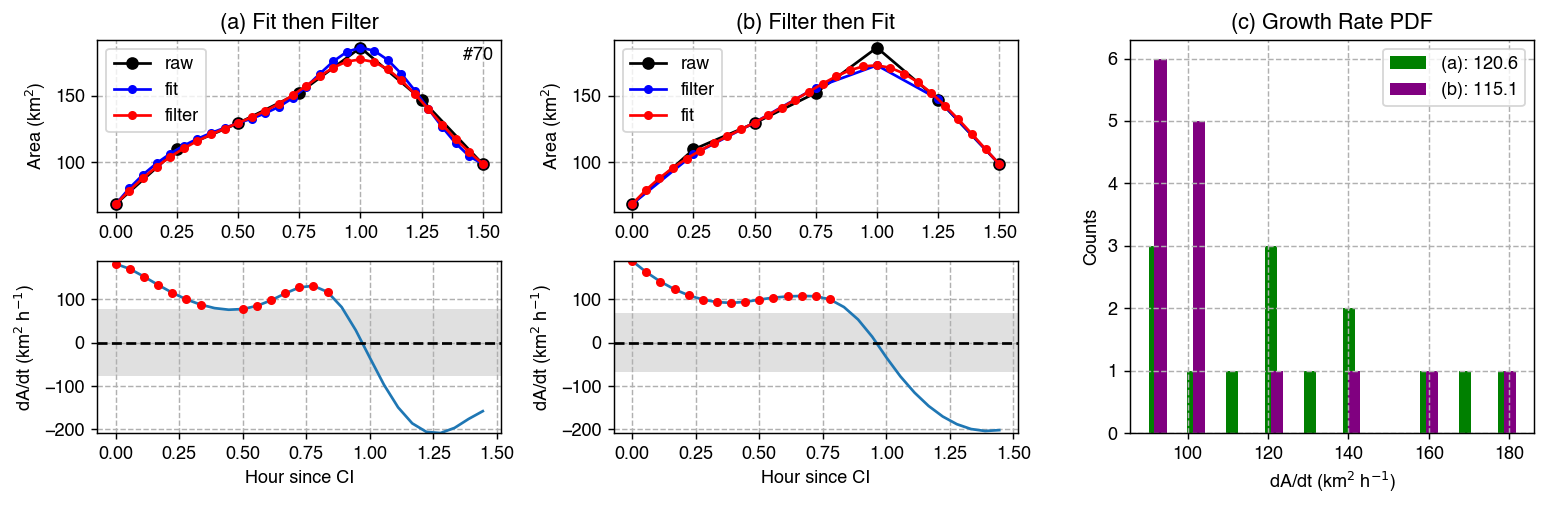

In [288]:
tidx = np.where(stats.lifetime == 7)[0]
cell_area = stats.cell_area.sel(tracks=tidx)
duration = stats.lifetime.sel(tracks=tidx)
# print(f'Number of tracks: {len(tidx)}')

tracknum = 70
icell_area = cell_area.isel(tracks=tracknum)
iduration = duration.isel(tracks=tracknum).values
# # Set up number of interpolated samples
# ns_interp = (iduration*4).astype(int)

idx = icell_area.values > 0
x = xtimes.values[idx]
y = icell_area.values[idx]

# Fit then then low-pass filter
Wn = 0.2
min_rate_percent = 0.1
X1, Y1, Ys1, dY1 = get_growth_rate1(x, y, iduration, Wn)
# Define growth stage
growth_flag1, dY_thres1 = define_growth_stage(X1, dY1, min_rate_percent)
ns_growth1 = np.count_nonzero(growth_flag1 == 1)
if (ns_growth1 > 1):
    dY_hist1, bins = np.histogram(dY1[growth_flag1 == 1])
    dY_avg1 = np.nanmean(dY1[growth_flag1 == 1])
# dY_hist1, bins = np.histogram(dY_sub1[dY_sub1 > 0])
# dY_avg1 = np.nanmean(dY_sub1[dY_sub1 > 0])

# Low-pass filter then fit
Wn2 = 0.6
X2, Ys2, ys2, dY2 = get_growth_rate2(x, y, iduration, Wn2)
# Define growth stage
growth_flag2, dY_thres2 = define_growth_stage(X2, dY2, min_rate_percent)
ns_growth2 = np.count_nonzero(growth_flag2 == 1)
if (ns_growth2 > 1):
    dY_hist2, bins = np.histogram(dY2[growth_flag2 == 1])
    dY_avg2 = np.nanmean(dY2[growth_flag2 == 1])
# dY_hist2, bins = np.histogram(dY_sub2[dY_sub2 > 0])
# dY_avg2 = np.nanmean(dY_sub2[dY_sub2 > 0])


# # Get positive dY indices
# idx_p = np.where(dY1 > dY_thres1)[0]
# gap = 1
# min_thick = 1
# # Get growth period indices
# gidx_s, gidx_e = get_layer_boundary(idx_p, gap, min_thick)
# g_dur = gidx_e - gidx_s

# # Get negative dY indices
# idx_n = np.where(dY1 < dY_thres1)[0]
# # Get decay period indices
# didx_s, didx_e = get_layer_boundary(idx_n, gap, min_thick)
# d_dur = didx_e - didx_s

# print('Growth:', gidx_s)
# print('Decay:', didx_s)
# # Combine growth and decayse period start/end indices, and sort them
# idx_s = np.sort(np.concatenate((gidx_s, didx_s)))
# idx_e = np.sort(np.concatenate((gidx_e, didx_e)))
# print('Combine:', idx_s)
# # Find growth indices in the combine index array
# junk, g1, junk = np.intersect1d(idx_s, gidx_s, return_indices=True)
# junk, d1, junk = np.intersect1d(idx_s, didx_s, return_indices=True)
# # print('Match growth index:', g1)
# # print('Match decay index:', d1)
# # Set growth period to 1, decay period to -1
# stages = np.zeros(len(idx_s), dtype=int)
# stages[g1] = 1
# stages[d1] = -1
# print('Stages:', stages)

# growth_flag = np.zeros(len(dY1), dtype=int)
# # Proceed if first stage is growth
# if stages[0] == 1:
#     # Set periods of first stage to 1
#     growth_flag[idx_s[0]:idx_e[0]] = 1
    
#     # Compute stage differences
#     stage_diff = np.diff(stages)
#     # Find indices of consecutive growth/decay stages (diff==0)
#     idx_consec = np.where(stage_diff == 0)[0]
#     if len(idx_consec) > 0:
#         # Loop over each consecutive stage
#         for p in range(len(idx_consec)):
#             # If it is a growth stage
#             idxp = idx_consec[p]
#             if stages[idxp] == 1:
#                 # Set the next stage flag
#                 growth_flag[idx_s[idxp+1]:idx_e[idxp+1]] = 1

if (ns_growth1 > 1) & (ns_growth2 > 1):
    
    mpl.rcParams['font.family'] = 'Helvetica'
    ymin, ymax = np.nanmin([dY1, dY2]), np.nanmax([dY1, dY2])
    msize = 4

    fig, axes = plt.subplots(2, 3, figsize=[12,4], dpi=130)
    ax = axes[0,0]
    ax.plot(x, y, 'o-', color='k', label='raw')
    ax.plot(X1, Y1, 'o-', color='b', label='fit', markersize=msize)
    ax.plot(X1, Ys1, 'o-', color='r', label='filter', markersize=msize)
    ax.legend()
    ax.set_ylabel('Area (km$^2$)')
    ax.grid(ls='--')
    ax.set_title('(a) Fit then Filter')
    ax.text(0.98, 0.88, f'#{tracknum}', ha='right', transform=ax.transAxes)

    ax = axes[1,0]
    ax.plot(X1[:-1], dY1)
    ax.plot(X1[:-1][growth_flag1==1], dY1[growth_flag1==1], 'o', color='r', markersize=msize)
    ax.axhspan(-dY_thres1, dY_thres1, facecolor='lightgray', alpha=0.7)
    ax.axhline(0, color='k', ls='--')
    ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
    ax.set_xlabel('Hour since CI')
    ax.set_ylim(ymin, ymax)
    ax.grid(ls='--')

    ax = axes[0,1]
    ax.plot(x, y, 'o-', color='k', label='raw')
    ax.plot(x, ys2, 'o-', color='b', label='filter', markersize=msize)
    ax.plot(X2, Ys2, 'o-', color='r', label='fit', markersize=msize)
    ax.legend()
    ax.set_ylabel('Area (km$^2$)')
    ax.grid(ls='--')
    ax.set_title('(b) Filter then Fit')

    ax = axes[1,1]
    ax.plot(X2[:-1], dY2)
    ax.plot(X2[:-1][growth_flag2==1], dY2[growth_flag2==1], 'o', color='r', markersize=msize)
    ax.axhspan(-dY_thres2, dY_thres2, facecolor='lightgray', alpha=0.7)
    ax.axhline(0, color='k', ls='--')
    ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
    ax.set_xlabel('Hour since CI')
    ax.set_ylim(ymin, ymax)
    ax.grid(ls='--')

    gs = axes[0,2].get_gridspec()
    for ax in axes[:,-1]:
        ax.remove()
    ax = fig.add_subplot(gs[:,-1])

    ax.bar(bins[:-1], dY_hist1, color='g', width=3, label=f'(a): {dY_avg1:.1f}')
    ax.bar(bins[:-1]+np.mean(np.diff(bins))*0.15, dY_hist2, color='purple', width=3, label=f'(b): {dY_avg2:.1f}')
    ax.set_xlabel('dA/dt (km$^2$ h$^{-1}$)')
    ax.set_ylabel('Counts')
    ax.set_title('(c) Growth Rate PDF')
    ax.grid(ls='--')
    ax.legend()

    fig.tight_layout()

In [247]:
stage_diff = np.diff(stages)
print(stages)
# print()
# Find indices of consecutive growth/decay stages
idx_consec = np.where(stage_diff == 0)[0]
print(stage_diff)
# stages[idx_consec+1]

# idx_s[idx_consec+1], idx_e[idx_consec+1]
p = 0
idxp = idx_consec[p]
stages[idxp]

[ 1  1 -1]
[ 0 -2]


1

In [133]:
tidx = np.where(stats.lifetime == 7)[0]
cell_area = stats.cell_area.sel(tracks=tidx)
duration = stats.lifetime.sel(tracks=tidx)
print(f'Number of tracks: {len(tidx)}')

tracknum = 95
icell_area = cell_area.isel(tracks=tracknum)
iduration = duration.isel(tracks=tracknum).values
# # Set up number of interpolated samples
# ns_interp = (iduration*4).astype(int)

idx = icell_area.values > 0
x = xtimes.values[idx]
y = icell_area.values[idx]

# # Perform spline fitting interpolation
# X_Y_Spline = make_interp_spline(x, y)
# X_ = np.linspace(x.min(), x.max(), ns_interp)
# Y_ = X_Y_Spline(X_)

# # Perform low-pass filter
# b, a = signal.butter(1, 0.2, analog=False)
# Y_s = signal.filtfilt(b, a, Y_)

# # Calculate area growth/decay rate (km2/hour)
# dY = np.diff(Y_s) / np.diff(X_)
# # Get the 10th percentile absolute area change rate
# dY_thres = np.quantile(np.abs(dY), 0.1)
# # Remove times when growth rate is small (stable stage)
# dY_sub = np.copy(dY)
# dY_sub[np.abs(dY) < dY_thres] = np.nan

Wn = 0.2
min_rate_percent = 0.1
X1, Y1, Ys1, dY1, dY_sub1 = get_growth_rate(x, y, iduration, Wn, min_rate_percent)
dY_hist1, bins = np.histogram(dY_sub1[dY_sub > 0])
dY_avg1 = np.nanmean(dY_sub1[dY_sub1 > 0])

fig, axes = plt.subplots(2, 3, figsize=[12,4], dpi=100)
ax = axes[0,0]
ax.plot(x, y, 'o-', color='k', label='raw')
ax.plot(X1, Y1, 'o-', color='b', label='fit')
ax.plot(X1, Ys1, 'o-', color='r', label='filter')
ax.legend()
ax.set_ylabel('Area (km$^2$)')
ax.grid(ls='--')
ax.set_title('(a) Fit then Filter')

ax = axes[1,0]
ax.plot(X1[:-1], dY1)
ax.plot(X1[:-1], dY_sub1, 'o--', color='r')
ax.axhline(0, color='k', ls='--')
ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
ax.set_xlabel('Hour since CI')
ax.grid(ls='--')

# Perform low-pass filter
b, a = signal.butter(1, 0.6, analog=False)
y_s = signal.filtfilt(b, a, y)

# Perform spline fitting interpolation
X_Y_Spline = make_interp_spline(x, y_s)
X_ = np.linspace(x.min(), x.max(), ns_interp)
Y_ = X_Y_Spline(X_)

# Calculate area growth/decay rate (km2/hour)
dY = np.diff(Y_) / np.diff(X_)
# Get the 10th percentile absolute area change rate
dY_thres = np.quantile(np.abs(dY), 0.1)
# Remove times when growth rate is small (stable stage)
dY_sub = np.copy(dY)
dY_sub[np.abs(dY) < dY_thres] = np.nan
dY_hist2, bins = np.histogram(dY_sub[dY_sub > 0])
dY_avg2 = np.nanmean(dY_sub[dY_sub > 0])

ax = axes[0,1]
ax.plot(x, y, 'o-', color='k', label='raw')
ax.plot(x, y_s, 'o-', color='b', label='filter')
ax.plot(X_, Y_, 'o-', color='r', label='fit')
ax.legend()
ax.set_ylabel('Area (km$^2$)')
ax.grid(ls='--')
ax.set_title('(b) Filter then Fit')

ax = axes[1,1]
ax.plot(X_[:-1], dY)
ax.plot(X_[:-1], dY_sub, 'o--', color='r')
ax.axhline(0, color='k', ls='--')
ax.set_ylabel('dA/dt (km$^2$ h$^{-1}$)')
ax.set_xlabel('Hour since CI')
ax.grid(ls='--')

gs = axes[0,2].get_gridspec()
for ax in axes[:,-1]:
    ax.remove()
ax = fig.add_subplot(gs[:,-1])

ax.bar(bins[:-1], dY_hist1, color='g', width=3, label=f'(a): {dY_avg1:.1f}')
ax.bar(bins[:-1]+np.mean(np.diff(bins))*0.15, dY_hist2, color='purple', width=3, label=f'(b): {dY_avg2:.1f}')
ax.set_xlabel('dA/dt (km$^2$ h$^{-1}$)')
ax.set_ylabel('Counts')
ax.set_title('(c) Growth Rate PDF')
ax.grid(ls='--')
ax.legend()

fig.tight_layout()

Number of tracks: 161


ValueError: autodetected range of [nan, nan] is not finite

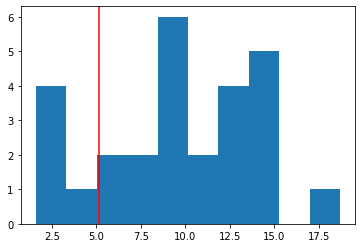

In [53]:
plt.hist(np.abs(dY))
dY_thres = np.quantile(np.abs(dY), 0.2)
plt.axvline(dY_thres, color='r')

In [26]:
xtimes.values[idx]

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75])

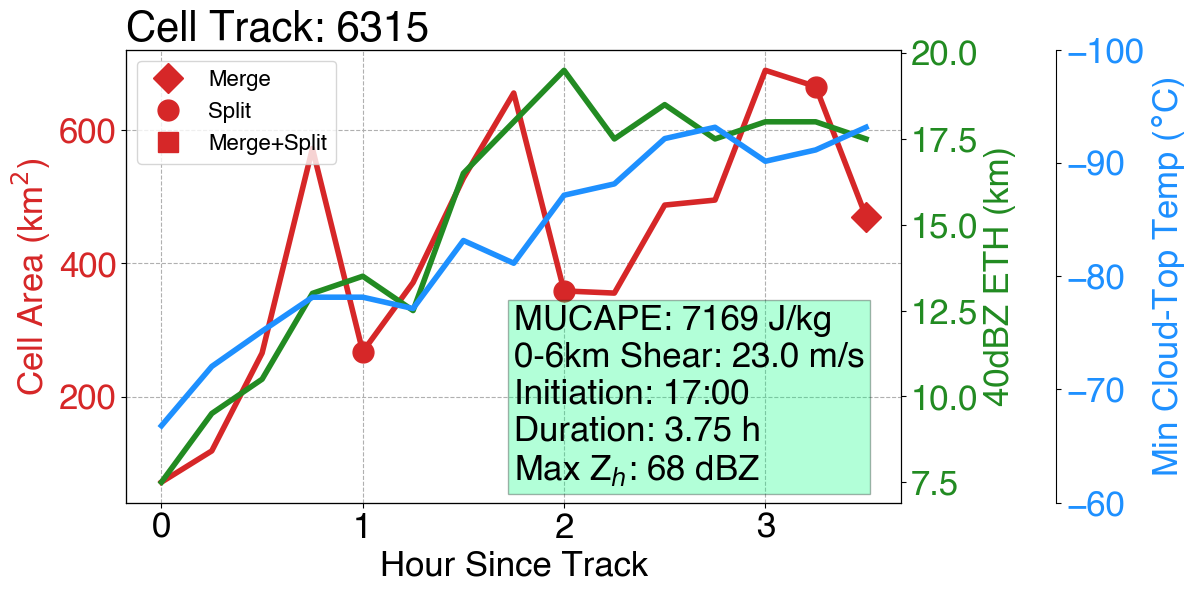

In [19]:
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Helvetica'
# fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)

fig, ax1 = plt.subplots(figsize=[10,6], dpi=100)

tracknum = 6314
# tracknum = 6320
icell_area = stats.cell_area.sel(tracks=tracknum)
ieth30 = stats.maxETH_30dbz.sel(tracks=tracknum)
ieth40 = stats.maxETH_40dbz.sel(tracks=tracknum)
ictt = stats.cloud_top_temperature_min.sel(tracks=tracknum) - 273.15
# Get track status flags
istats = stats.status.sel(tracks=tracknum)
tidx_split = np.where((istats == 4) | (istats == 5) | (istats == 16))[0]
tidx_merge = np.where((istats == 2) | (istats == 15) | (istats == 37))[0]
tidx_mergesplit = np.where((istats == 18) | (istats == 46))[0]

imucape = stats.CAPE_mu.sel(tracks=tracknum, reltime=0).values
i850qv = stats.rvap_850mb.sel(tracks=tracknum, reltime=0).values
ishear6km = stats.shear_mag_bulk_0to6km.sel(tracks=tracknum, reltime=0).values
ilifetime = stats.lifetime.sel(tracks=tracknum).values * time_res
imaxdbz = stats.maxdbz.sel(tracks=tracknum).max(dim='times').values
itime0 = stats.basetime.sel(tracks=tracknum, times=0).dt.strftime('%H:%M').values

color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
ax1.set_ylabel('Cell Area (km$^{2}$)', color=color)
ax1.set_xlabel('Hour Since Track')
ax1.set_title(f'Cell Track: {tracknum+1}', loc='left')
ax1.plot(xtimes, icell_area, color=color, lw=4)
# Overplot track status on cell area
ax1.plot(xtimes[tidx_merge], icell_area[tidx_merge], 'D', color=color, markersize=15, label='Merge')
ax1.plot(xtimes[tidx_split], icell_area[tidx_split], 'o', color=color, markersize=15, label='Split')
ax1.plot(xtimes[tidx_mergesplit], icell_area[tidx_mergesplit], 's', color=color, markersize=15, label='Merge+Split')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(which='major', ls='--')
ax1.legend(ncol=1, loc='upper left', fontsize=16)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'forestgreen'
ax2.set_ylabel('40dBZ ETH (km)', color=color)  # we already handled the x-label with ax1
ax2.plot(xtimes, ieth40, color=color, lw=4)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines['right'].set_position(("axes", 1.2))
color = 'dodgerblue'
# ax3.set_ylabel('40dBZ ETH (km)', color=color)  # we already handled the x-label with ax1
# ax3.plot(xtimes, ieth40, color=color, lw=4)
ax3.set_ylabel('Min Cloud-Top Temp ($\degree$C)', color=color)  # we already handled the x-label with ax1
# ax3.set_ylim(210, 170)
ax3.set_ylim(-60, -100)
ax3.plot(xtimes, ictt, color=color, lw=4)
ax3.tick_params(axis='y', labelcolor=color)

# param_texts = f'MUCAPE: {imucape:.0f} J/kg\nq$_v$850hPa: {i850qv:.01f} g/kg\n0-6km Shear: {ishear6km:.01f} m/s\n'+\
#             f'Initiation: {itime0}\nDuration: {ilifetime} h\nMax Z$_h$: {imaxdbz:.0f} dBZ'
param_texts = f'MUCAPE: {imucape:.0f} J/kg\n0-6km Shear: {ishear6km:.01f} m/s\n'+\
            f'Initiation: {itime0}\nDuration: {ilifetime} h\nMax Z$_h$: {imaxdbz:.0f} dBZ'
t1 = ax1.text(0.5, 0.05, param_texts, transform=ax1.transAxes, zorder=10)
t1.set_bbox(dict(facecolor='springgreen', alpha=0.3, edgecolor='k'))

# fig.tight_layout()
figname = f'{figdir}case_celltrack_info_{tracknum+1}.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

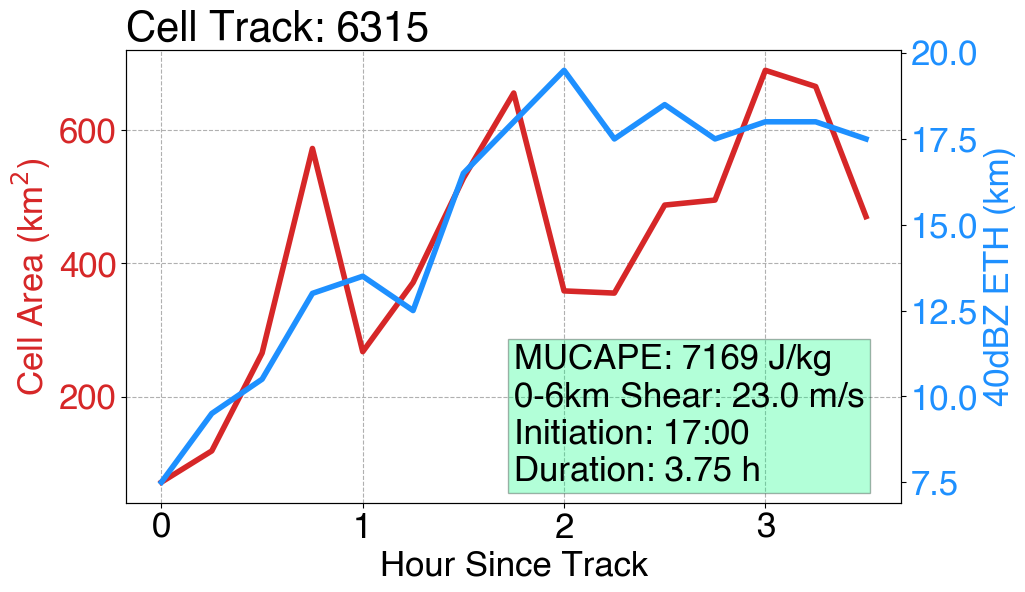

In [20]:
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Helvetica'
# fig, axes = plt.subplots(1, 2, figsize=[10,3], dpi=100)

fig, ax1 = plt.subplots(figsize=[10,6], dpi=100)

tracknum = 6314
icell_area = stats.cell_area.sel(tracks=tracknum)
ieth30 = stats.maxETH_30dbz.sel(tracks=tracknum)
ieth40 = stats.maxETH_40dbz.sel(tracks=tracknum)
ictt = stats.cloud_top_temperature_min.sel(tracks=tracknum) - 273.15
# Get track status flags
istats = stats.status.sel(tracks=tracknum)
tidx_split = np.where((istats == 4) | (istats == 5) | (istats == 16))[0]
tidx_merge = np.where((istats == 2) | (istats == 15) | (istats == 37))[0]
tidx_mergesplit = np.where((istats == 18) | (istats == 46))[0]

imucape = stats.CAPE_mu.sel(tracks=tracknum, reltime=0).values
i850qv = stats.rvap_850mb.sel(tracks=tracknum, reltime=0).values
ishear6km = stats.shear_mag_bulk_0to6km.sel(tracks=tracknum, reltime=0).values
ilifetime = stats.lifetime.sel(tracks=tracknum).values * time_res
imaxdbz = stats.maxdbz.sel(tracks=tracknum).max(dim='times').values
itime0 = stats.basetime.sel(tracks=tracknum, times=0).dt.strftime('%H:%M').values

color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
ax1.set_ylabel('Cell Area (km$^{2}$)', color=color)
ax1.set_xlabel('Hour Since Track')
ax1.set_title(f'Cell Track: {tracknum+1}', loc='left')
ax1.plot(xtimes, icell_area, color=color, lw=4)
# Overplot track status on cell area
# ax1.plot(xtimes[tidx_merge], icell_area[tidx_merge], 'D', color=color, markersize=15, label='Merge')
# ax1.plot(xtimes[tidx_split], icell_area[tidx_split], 'o', color=color, markersize=15, label='Split')
# ax1.plot(xtimes[tidx_mergesplit], icell_area[tidx_mergesplit], 's', color=color, markersize=15, label='Merge+Split')
# ax1.legend(ncol=1, loc='upper left', fontsize=16)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(which='major', ls='--')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'dodgerblue'
ax2.set_ylabel('40dBZ ETH (km)', color=color)  # we already handled the x-label with ax1
ax2.plot(xtimes, ieth40, color=color, lw=4)
ax2.tick_params(axis='y', labelcolor=color)

# ax3 = ax1.twinx()
# # Offset the right spine of twin2.  The ticks and label have already been
# # placed on the right by twinx above.
# ax3.spines['right'].set_position(("axes", 1.2))
# color = 'dodgerblue'
# # ax3.set_ylabel('40dBZ ETH (km)', color=color)  # we already handled the x-label with ax1
# # ax3.plot(xtimes, ieth40, color=color, lw=4)
# ax3.set_ylabel('Min Cloud-Top Temp (K)', color=color)  # we already handled the x-label with ax1
# ax3.set_ylim(210, 170)
# ax3.plot(xtimes, ictt, color=color, lw=4)
# ax3.tick_params(axis='y', labelcolor=color)

param_texts = f'MUCAPE: {imucape:.0f} J/kg\n0-6km Shear: {ishear6km:.01f} m/s\n'+\
            f'Initiation: {itime0}\nDuration: {ilifetime} h'
t1 = ax1.text(0.5, 0.05, param_texts, transform=ax1.transAxes)
t1.set_bbox(dict(facecolor='springgreen', alpha=0.3, edgecolor='k'))

# fig.tight_layout()
figname = f'{figdir}case_celltrack_info_{tracknum+1}_simple.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [21]:
figname

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/case_celltrack_info_6315_simple.png'

In [22]:
f'{stats.CAPE_mu.sel(tracks=6314, reltime=0).values:.0f} J/kg'

'7169 J/kg'

In [23]:
status.where(lifetime > 0.5, drop=True)

<xarray.DataArray 'status' (tracks: 21, times: 60)>
array([[ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  0., ..., nan, nan, nan],
       [ 2.,  1.,  1., ..., nan, nan, nan],
       ...,
       [13.,  5., 15., ..., nan, nan, nan],
       [ 1.,  1.,  0., ..., nan, nan, nan],
       [ 1.,  1.,  0., ..., nan, nan, nan]])
Coordinates:
  * tracks   (tracks) int32 6314 6315 6316 6318 6320 ... 6399 6401 6402 6403
  * times    (times) int32 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Attributes:
    long_name:  Flag indicating evolution / behavior for each cloud in a track
    units:      unitless
    valid_min:  0
    valid_max:  65
    comments:   0: Track stops;  1: Simple track continuation;  2: This is th...

In [24]:
lifetime_min = 1
lifetime_long = lifetime.where(lifetime > lifetime_min, drop=True)
cell_area_long = cell_area.where(lifetime > lifetime_min, drop=True)
eth30_long = eth30.where(lifetime > lifetime_min, drop=True)
eth40_long = eth40.where(lifetime > lifetime_min, drop=True)
start_split_tracknumber_long = start_split_tracknumber.where(lifetime > lifetime_min, drop=True)
end_merge_tracknumber_long = end_merge_tracknumber.where(lifetime > lifetime_min, drop=True)
status_long = status.where(lifetime > lifetime_min, drop=True)
ctt_long = ctt.where(lifetime > lifetime_min, drop=True)

ntracks_long = lifetime_long.size
print(f'Number of long tracks: {ntracks_long}')

Number of long tracks: 10


In [25]:
ctt_long = ctt.where(lifetime > lifetime_min, drop=True)

In [26]:
tracks_long = lifetime_long.tracks
for itrack in range(len(tracks_long)):
    print(itrack, lifetime_long[itrack])

0 <xarray.DataArray 'lifetime' ()>
array(3.75)
Coordinates:
    tracks   int32 6314
1 <xarray.DataArray 'lifetime' ()>
array(2.25)
Coordinates:
    tracks   int32 6316
2 <xarray.DataArray 'lifetime' ()>
array(1.75)
Coordinates:
    tracks   int32 6318
3 <xarray.DataArray 'lifetime' ()>
array(5.)
Coordinates:
    tracks   int32 6320
4 <xarray.DataArray 'lifetime' ()>
array(2.25)
Coordinates:
    tracks   int32 6357
5 <xarray.DataArray 'lifetime' ()>
array(1.5)
Coordinates:
    tracks   int32 6387
6 <xarray.DataArray 'lifetime' ()>
array(2.25)
Coordinates:
    tracks   int32 6391
7 <xarray.DataArray 'lifetime' ()>
array(4.5)
Coordinates:
    tracks   int32 6397
8 <xarray.DataArray 'lifetime' ()>
array(1.5)
Coordinates:
    tracks   int32 6399
9 <xarray.DataArray 'lifetime' ()>
array(2.)
Coordinates:
    tracks   int32 6401


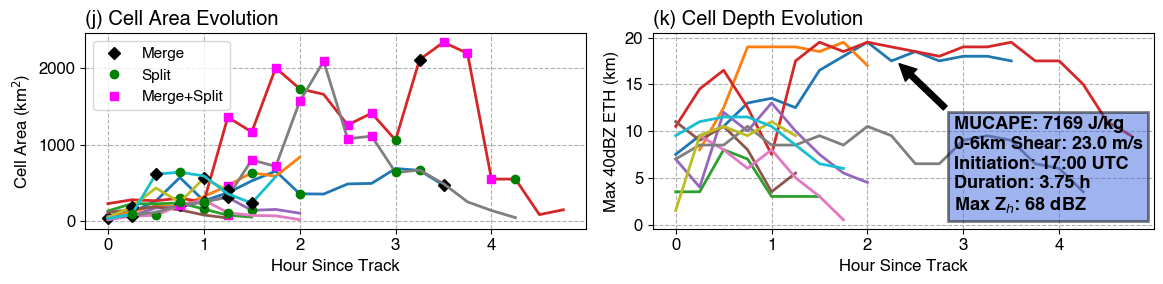

In [28]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)

colors = {'m':'k', 's':'g', 'ms':'magenta'}
ax1 = axes[0]
for itrack in range(0, ntracks_long):
    icell_area = cell_area_long.values[itrack,:]
    # Get track status flags
    istats = status_long.values[itrack,:]
    tidx_split = np.where((istats == 4) | (istats == 5) | (istats == 16))[0]
    tidx_merge = np.where((istats == 2) | (istats == 15) | (istats == 37))[0]
    tidx_mergesplit = np.where((istats == 18) | (istats == 46))[0]

#     if (~np.isnan(end_merge_tracknumber_long.values[itrack])):
    ax1.plot(xtimes, icell_area, lw=2)
    # Overplot track status on cell area
    ax1.plot(xtimes[tidx_merge], icell_area[tidx_merge], 'D', color=colors['m'], markersize=6, label='Merge')
    ax1.plot(xtimes[tidx_split], icell_area[tidx_split], 'o', color=colors['s'], markersize=6, label='Split')
    ax1.plot(xtimes[tidx_mergesplit], icell_area[tidx_mergesplit], 's', color=colors['ms'], markersize=6, label='Merge+Split')

legend_elements = [mpl.lines.Line2D([0], [0], marker='D', color=colors['m'], lw=0, markersize=6, label='Merge'),
                   mpl.lines.Line2D([0], [0], marker='o', color=colors['s'], lw=0, markersize=6, label='Split'),
                   mpl.lines.Line2D([0], [0], marker='s', color=colors['ms'], lw=0, markersize=6, label='Merge+Split')]
ax1.legend(handles=legend_elements, ncol=1, loc='upper left', fontsize=11)
ax1.set_ylabel('Cell Area (km$^{2}$)')
ax1.set_xlabel('Hour Since Track')
ax1.set_title('(j) Cell Area Evolution', loc='left')
ax1.grid(ls='--')

ax2 = axes[1]

tracknum = 6314
imucape = stats.CAPE_mu.sel(tracks=tracknum, reltime=0).values
i850qv = stats.rvap_850mb.sel(tracks=tracknum, reltime=0).values
ishear6km = stats.shear_mag_bulk_0to6km.sel(tracks=tracknum, reltime=0).values
ilifetime = stats.lifetime.sel(tracks=tracknum).values * time_res
imaxdbz = stats.maxdbz.sel(tracks=tracknum).max(dim='times').values
itime0 = stats.basetime.sel(tracks=tracknum, times=0).dt.strftime('%H:%M').values

for itrack in range(0, ntracks_long):
#     if (~np.isnan(end_merge_tracknumber_long.values[itrack])):
    ax2.plot(xtimes, eth40_long.values[itrack,:], lw=2)
ax2.set_ylabel('Max 40dBZ ETH (km)')
ax2.set_xlabel('Hour Since Track')
ax2.set_title('(k) Cell Depth Evolution', loc='left')
ax2.grid(ls='--')

param_texts = f'MUCAPE: {imucape:.0f} J/kg\n0-6km Shear: {ishear6km:.01f} m/s\n'+\
            f'Initiation: {itime0} UTC\nDuration: {ilifetime} h\nMax Z$_h$: {imaxdbz:.0f} dBZ'
# t1 = ax2.text(0.54, 0.07, param_texts, fontweight='bold', transform=ax2.transAxes, zorder=10)
# t1.set_bbox(dict(facecolor='royalblue', alpha=0.5, edgecolor='k'))
bbox_props = dict(boxstyle="square,pad=0.3", fc="royalblue", ec="k", lw=2, alpha=0.5)
ax2.annotate(param_texts, xy=(2.3, 17.5), xycoords='data',
             xytext=(2.9, 1), textcoords='data', weight='bold', fontsize=13, 
             arrowprops=dict(facecolor='black', shrink=0.05), bbox=bbox_props, 
             horizontalalignment='left', verticalalignment='bottom')

fig.tight_layout()
figname = f'{figdir}case_cellarea_ETH40dbz_track_evolution_{start_datetime}.png'
fig.savefig(figname, dpi=600, bbox_inches='tight', facecolor='w')

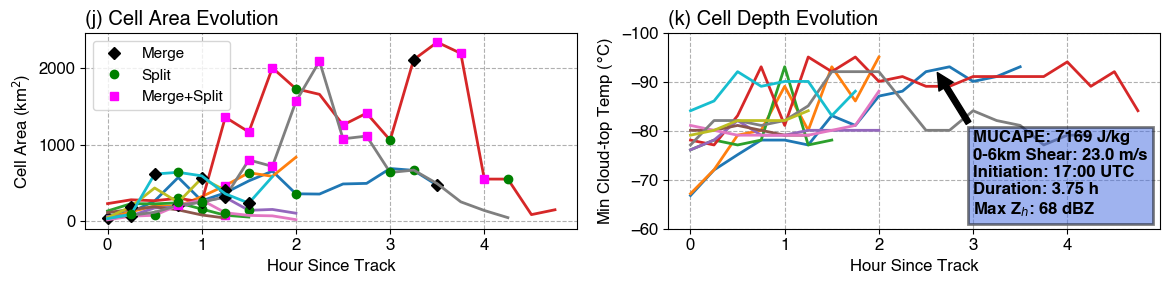

In [40]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=[12,3], dpi=100)

colors = {'m':'k', 's':'g', 'ms':'magenta'}
ax1 = axes[0]
for itrack in range(0, ntracks_long):
    icell_area = cell_area_long.values[itrack,:]
    # Get track status flags
    istats = status_long.values[itrack,:]
    tidx_split = np.where((istats == 4) | (istats == 5) | (istats == 16))[0]
    tidx_merge = np.where((istats == 2) | (istats == 15) | (istats == 37))[0]
    tidx_mergesplit = np.where((istats == 18) | (istats == 46))[0]

#     if (~np.isnan(end_merge_tracknumber_long.values[itrack])):
    ax1.plot(xtimes, icell_area, lw=2)
    # Overplot track status on cell area
    ax1.plot(xtimes[tidx_merge], icell_area[tidx_merge], 'D', color=colors['m'], markersize=6, label='Merge')
    ax1.plot(xtimes[tidx_split], icell_area[tidx_split], 'o', color=colors['s'], markersize=6, label='Split')
    ax1.plot(xtimes[tidx_mergesplit], icell_area[tidx_mergesplit], 's', color=colors['ms'], markersize=6, label='Merge+Split')

legend_elements = [mpl.lines.Line2D([0], [0], marker='D', color=colors['m'], lw=0, markersize=6, label='Merge'),
                   mpl.lines.Line2D([0], [0], marker='o', color=colors['s'], lw=0, markersize=6, label='Split'),
                   mpl.lines.Line2D([0], [0], marker='s', color=colors['ms'], lw=0, markersize=6, label='Merge+Split')]
ax1.legend(handles=legend_elements, ncol=1, loc='upper left', fontsize=11)
ax1.set_ylabel('Cell Area (km$^{2}$)')
ax1.set_xlabel('Hour Since Track')
ax1.set_title('(j) Cell Area Evolution', loc='left')
ax1.grid(ls='--')

ax2 = axes[1]

tracknum = 6314
imucape = stats.CAPE_mu.sel(tracks=tracknum, reltime=0).values
i850qv = stats.rvap_850mb.sel(tracks=tracknum, reltime=0).values
ishear6km = stats.shear_mag_bulk_0to6km.sel(tracks=tracknum, reltime=0).values
ilifetime = stats.lifetime.sel(tracks=tracknum).values * time_res
imaxdbz = stats.maxdbz.sel(tracks=tracknum).max(dim='times').values
itime0 = stats.basetime.sel(tracks=tracknum, times=0).dt.strftime('%H:%M').values

for itrack in range(0, ntracks_long):
    ax2.plot(xtimes, ctt_long.values[itrack,:], lw=2)
ax2.set_ylabel('Min Cloud-top Temp ($\degree$C)')
# ax2.set_ylim(210, 175)
ax2.set_ylim(-60, -100)
ax2.set_xlabel('Hour Since Track')
ax2.set_title('(k) Cell Depth Evolution', loc='left')
ax2.grid(ls='--')

param_texts = f'MUCAPE: {imucape:.0f} J/kg\n0-6km Shear: {ishear6km:.01f} m/s\n'+\
            f'Initiation: {itime0} UTC\nDuration: {ilifetime} h\nMax Z$_h$: {imaxdbz:.0f} dBZ'
# t1 = ax2.text(0.54, 0.07, param_texts, fontweight='bold', transform=ax2.transAxes, zorder=10)
# t1.set_bbox(dict(facecolor='royalblue', alpha=0.5, edgecolor='k'))
bbox_props = dict(boxstyle="square,pad=0.3", fc="royalblue", ec="k", lw=2, alpha=0.5)
ax2.annotate(param_texts, xy=(2.6, -92.6), xycoords='data',
             xytext=(3, -62), textcoords='data', weight='bold', fontsize=12, 
             arrowprops=dict(facecolor='black', shrink=0.05), bbox=bbox_props, 
             horizontalalignment='left', verticalalignment='bottom')

fig.tight_layout()
figname = f'{figdir}case_cellarea_ctt_track_evolution_{start_datetime}.png'
fig.savefig(figname, dpi=600, bbox_inches='tight', facecolor='w')

In [42]:
f'{figdir}case_cellarea_ETH40dbz_track_evolution_{start_datetime}.png'

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/case_cellarea_ETH40dbz_track_evolution_2019-01-25T17.png'

In [43]:
f'{figdir}case_cellarea_ctt_track_evolution_{start_datetime}.png'

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_environment_stats_jim/case_cellarea_ctt_track_evolution_2019-01-25T17.png'

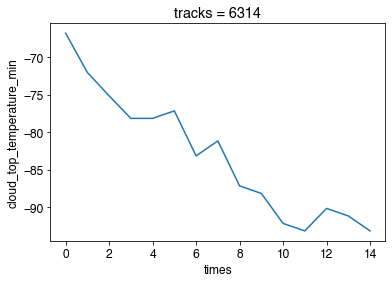

In [34]:
ctt_long.isel(tracks=0).plot()